In [1]:
import sys
import logging
import pickle
import yaml
import matplotlib.cm as cm
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import configs

In [2]:
sys.path.append('..')
from scripts.model_parameters.dicarlo_swap import *

# Parameters

In [37]:
internal_dim = 16
network_yaml = 'dm'
generic_exp_name_pre = 'postbug_gridworld8x8_shuffobs'
generic_exp_name_post = f'dicarlo_swap_{generic_exp_name_pre}'
param_loading_func = postbug_contig

In [38]:
engram_dir = '/Volumes/aronov-locker/Ching/rl/'
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/' # Axon path

# Loading analysis dataframes and swap parameters

In [39]:
def get_repr_df(generic_exp_name):
    exp_name = f'{generic_exp_name}_{network_yaml}_dim{internal_dim}'
    nnets_dir = f'{engram_dir}nnets/{exp_name}/'
    analysis_dir = f'{engram_dir}analysis/{exp_name}/'
    with open(f'{analysis_dir}representation_df.p', 'rb') as f:
        repr_df = pickle.load(f)
    return repr_df

In [40]:
def get_fr_map(generic_exp_name, model, i, unit):
    repr_df = get_repr_df(generic_exp_name)
    _df = repr_df[repr_df['model'] == f'{generic_exp_name}_{model}']
    _df = _df[_df['iteration'] == i]
    
    width = np.max(_df['x']) + 2
    height = np.max(_df['y']) + 2
    _sample = np.array(_df.head(1)['latents'].item())
    n_units = _sample.size
    heatmap = np.zeros((n_units, width, height))
    for _, row in _df.iterrows():
        x = row['x']
        y = row['y']
        latents = np.array(row['latents'])
        heatmap[:,x,y] = latents
    m = heatmap[unit]
    m[m<0] = 0
    return m

In [41]:
swap_params = param_loading_func()

# Make encoder receptive fields

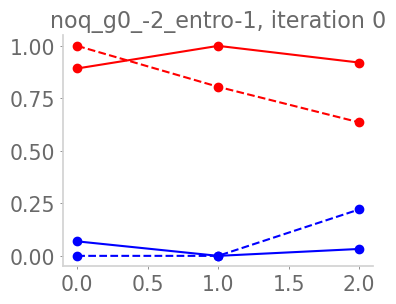

In [42]:
for key in swap_params.keys():
    _swap_params = swap_params[key]
    key_split = key[::-1].index('_')
    model = key[:-key_split-1]
    i = int(key[-key_split:])
    unit = int(_swap_params['chosen_unit'])
    try:
        fr_pre = get_fr_map(generic_exp_name_pre, model, i, unit)
        fr_post = get_fr_map(generic_exp_name_post, model, i, unit)
        fr_pre /= fr_pre.max()
        fr_post /= fr_post.max()
    except:
        continue
        
    plt.figure(figsize=(4,3))
    a = fr_pre[_swap_params['a']]
    b = fr_pre[_swap_params['b']]
    c = fr_pre[_swap_params['c']]
    d = fr_pre[_swap_params['d']]
    e = fr_pre[_swap_params['e']]
    f = fr_pre[_swap_params['f']]
    plt.plot([0,1,2], [a,b,c], color='red', marker='o')
    plt.plot([0,1,2], [d,e,f], color='blue', marker='o')
    a = fr_post[_swap_params['a']]
    b = fr_post[_swap_params['b']]
    c = fr_post[_swap_params['c']]
    d = fr_post[_swap_params['d']]
    e = fr_post[_swap_params['e']]
    f = fr_post[_swap_params['f']]
    plt.plot([0,1,2], [a,b,c], color='red', linestyle='--', marker='o')
    plt.plot([0,1,2], [d,e,f], color='blue', linestyle='--', marker='o')
    plt.title(f'{model}, iteration {i}')